In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
ICT Capstone 2022 
Electricity Demand Forecasting with Machine Learning

@authors: 
Viriya Duch Sam
Su Hyun Kim
Kim Khanh Tran
Paola Abrogueña

PART 4: LSTM Neural Network
Version 1.1.2 (Final)

Objectives: 
- 

"""

'\nICT Capstone 2022 \nElectricity Demand Forecasting with Machine Learning\n\n@authors: \nViriya Duch Sam\nSu Hyun Kim\nKim Khanh Tran\nPaola Abrogueña\n\nPART 4: Modeling\nVersion 1.1.1\n\nObjectives: \n- \n\n'

In [10]:
import os

## Data manipulation
import numpy as np
import pandas as pd 
from datetime import datetime

## Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Scaler
from sklearn.preprocessing import MinMaxScaler

## Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Keras model and layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import pickle

In [13]:
sns.set_style('whitegrid')

In [3]:
# Import dataset containing all features
fname = "engineered_data.csv"

df = pd.read_csv(fname)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2015-01-01 to 2020-10-06
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   demand                  2106 non-null   float64
 1   min_temperature         2106 non-null   float64
 2   max_temperature         2106 non-null   float64
 3   solar_exposure          2106 non-null   float64
 4   rainfall                2106 non-null   float64
 5   school_day              2106 non-null   int64  
 6   holiday                 2106 non-null   int64  
 7   month                   2106 non-null   int64  
 8   season                  2106 non-null   int64  
 9   day_of_week             2106 non-null   int64  
 10  weekend                 2106 non-null   int64  
 11  pre_covid               2106 non-null   int64  
 12  demand_7_days_lag       2106 non-null   float64
 13  demand_14_days_lag      2106 non-null   float64
 14  demand_28_days_lag    

# Split dataset
We will use a 60-20-20 train-validation-test split for our LSTM model.

In [4]:
split60 = int(len(df) * 0.6)
split80 = int(len(df) * 0.8)
df_train = df[:split60]
df_val = df[split60:split80]
df_test = df[split80:]

X_train, y_train = (df_train, df_train.demand)
X_val, y_val = (df_val, df_val.demand)
X_test, y_test = (df_test, df_test.demand)

In [5]:
train = df_train
val= df_val
test = df_test

In [6]:
train.shape, val.shape, test.shape

((1263, 57), (421, 57), (422, 57))

# Convert time series into supervised learning
A Multivariate time series has more than one time-dependent variable. Each variable depends not only on its past values but also has some dependency on other variables. This dependency is used for forecasting future values.

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    
    n_vars = data.shape[1]
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)    
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [8]:
values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series.
values = reframed.values
split60 = int(values.shape[0] * 0.7)
split80 = int(values.shape[0] * 0.9)

train = values[ :split60, :]
val = values[split60: split80,: ]
test = values[split80: , :]
train_x, train_y = train[:, :-1], train[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [9]:
## Normalising values 
train_x.shape, val_x.shape, test_x.shape

((1473, 1, 57), (421, 1, 57), (211, 1, 57))

# Build and Compile LSTM

In [25]:
# Define Model
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate = 0.0002))
print(model.summary(), '\n')

# Callback for earling stopping
callback = [EarlyStopping(patience = 40, monitor='val_loss', restore_best_weights=True, min_delta=0.002)]

# Network fitting
history = model.fit(train_x, train_y, epochs=300, batch_size=64, validation_data=(val_x, val_y), verbose=1, shuffle=False, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               63200     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 63,301
Trainable params: 63,301
Non-trainable params: 0
_________________________________________________________________
None 

Epoch 1/300
24/24 [==============================] - 1s 13ms/step - loss: 0.0697 - val_loss: 0.0316
Epoch 2/300
24/24 [==============================] - 0s 3ms/step - loss: 0.0328 - val_loss: 0.0292
Epoch 3/300
24/24 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0263
Epoch 4/3

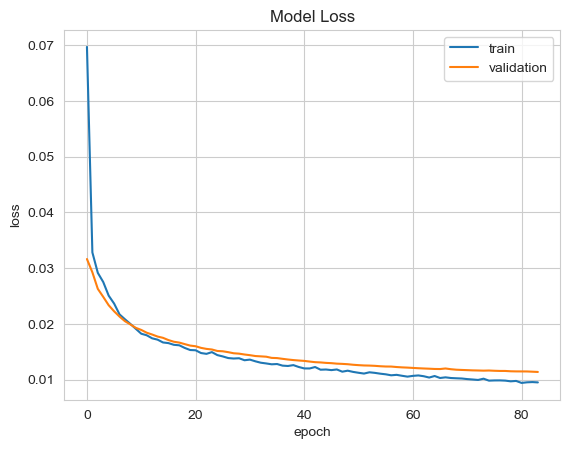

In [26]:
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
# Predict on validation data
yhat_val = model.predict(val_x)

# Invert scaling for predicted values
size = df.shape[1]
val_x_reshaped = val_x.reshape((val_x.shape[0], size))
inv_yhat_val = np.concatenate((yhat_val, val_x_reshaped[:, 1-size:]), axis=1)
inv_yhat_val = scaler.inverse_transform(inv_yhat_val)
inv_yhat_val = inv_yhat_val[:,0]

# Invert scaling for actual values
val_y_reshaped = val_y.reshape((len(val_y), 1))
inv_y_val = np.concatenate((val_y_reshaped, val_x_reshaped[:, 1-size:]), axis=1)
inv_y_val = scaler.inverse_transform(inv_y_val)
inv_y_val = inv_y_val[:,0]

14/14 [==============================] - 0s 769us/step


In [28]:
# Predict on test data
yhat = model.predict(test_x)

# Invert scaling for prediction
size = df.shape[1]
test_x_reshaped = test_x.reshape((test_x.shape[0], size))
inv_yhat = np.concatenate((yhat, test_x_reshaped[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshaped, test_x_reshaped[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

7/7 [==============================] - 0s 834us/step


In [29]:
## Validation metrics
rmse_val = np.sqrt(mean_squared_error(inv_y_val, inv_yhat_val))
print('* Validation RMSE: %.2f' % rmse_val)

actual_average_val = inv_y_val.mean()
print('* Validation Actual Average Demand: '+ str(np.round(actual_average_val, 2)))

# Mean Absolute Error (MAE)
MAE_val = mean_absolute_error(inv_y_val, inv_yhat_val)
print('* Validation Mean Absolute Error (MAE): ' + str(np.round(MAE_val, 2)))

MSE_val = mean_squared_error(inv_y_val, inv_yhat_val)
print('* Validation Mean Squared Error (MSE): ' + str(np.round(MSE_val, 2)))

MAPE_val = mean_absolute_percentage_error(inv_y_val, inv_yhat_val)
print('* Validation Median Absolute Percentage Error (MAPE): ' + str(np.round(MAPE_val*100, 2)) + ' %')

* Validation RMSE: 9781.05
* Validation Actual Average Demand: 117457.69
* Validation Mean Absolute Error (MAE): 7605.18
* Validation Mean Squared Error (MSE): 95669018.45
* Validation Median Absolute Percentage Error (MAPE): 6.54 %


In [30]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('* Test RMSE: %.2f' % rmse)

actual_average = inv_y.mean()
print('* Test Actual Average Demand: '+ str(np.round(actual_average, 2)))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(inv_y, inv_yhat)
print('* Test Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

MSE = mean_squared_error(inv_y, inv_yhat)
print('* Test Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

MAPE = mean_absolute_percentage_error(inv_y, inv_yhat)
print('* Test Median Absolute Percentage Error (MAPE): ' + str(np.round(MAPE*100, 2)) + ' %')

* Test RMSE: 7947.66
* Test Actual Average Demand: 118366.09
* Test Mean Absolute Error (MAE): 6395.28
* Test Mean Squared Error (MSE): 63165369.68
* Test Median Absolute Percentage Error (MAPE): 5.53 %


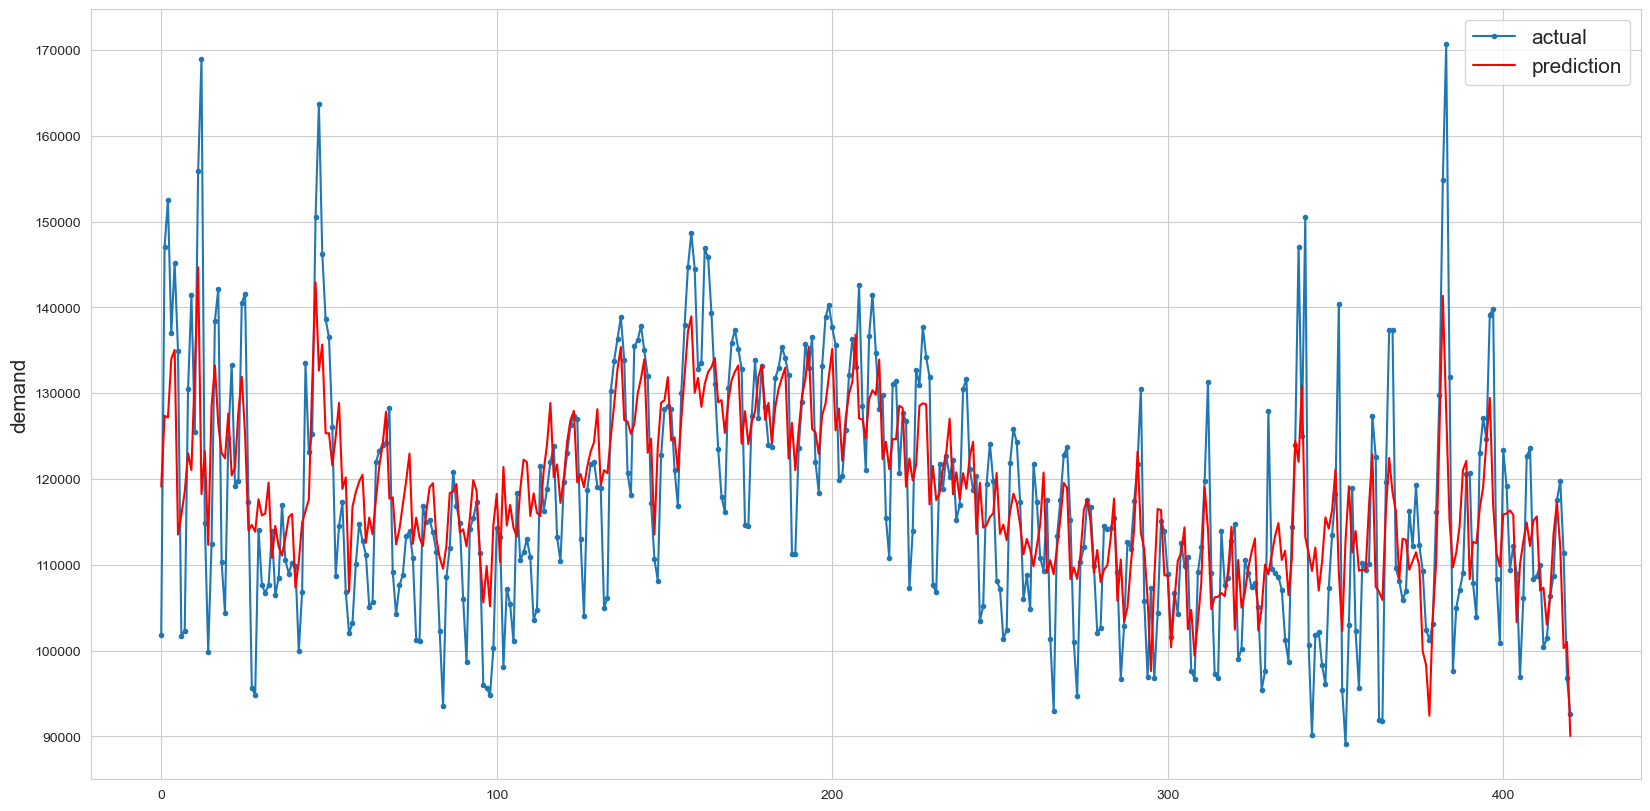

In [31]:
# Plot comparison
plt.figure(figsize=(20,10)) 
plt.plot(inv_y_val, marker='.', label="actual")
plt.plot(inv_yhat_val, 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.legend(fontsize=15)
plt.show()

In [32]:
# Make new dataframe for results
datetime = df.iloc[test.shape[0]:, ].index
datetime = datetime.to_numpy()

new = pd.DataFrame(zip(datetime, inv_y, inv_yhat), columns=['date','actual','prediction'])
new['date'] = pd.to_datetime(new['date'])
new = new.set_index('date').sort_index()

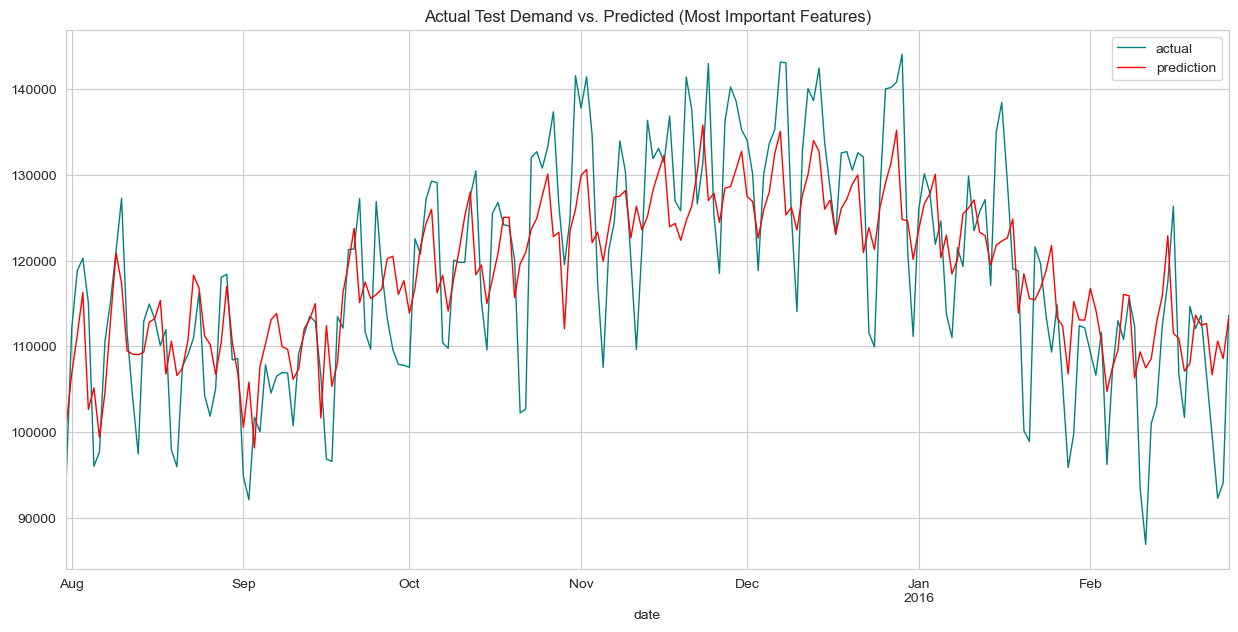

In [33]:
# Closer Look
_ = new[['actual', 'prediction']].plot(figsize=(15,7), color=['teal', 'red'], lw=1, title='Actual Test Demand vs. Predicted (Most Important Features)')

# Save Model
Keras model cannot be saved into pickle efficiently, so we will save into JSON file instead.

In [39]:
# pip install h5py

In [38]:
# serialize model to JSON
model_json = model.to_json()
with open("LSTM.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("LSTM_weights.h5")
print("Saved model to disk")

Saved model to disk


# For future loading of model:

##### #load json and create model:
json_file = open('LSTM.json', 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

##### #load weights into new model:
loaded_model.load_weights("LSTM_weights.h5")

(Compile model using loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate = 0.0002)))